In [4]:
from language_analysis import load_latest_interaction, load_all_interactions
import math
import torch
import networkx as nx
import matplotlib.pyplot as plt
from egg.core.language_analysis import TopographicSimilarity

In [2]:
interaction_obj = load_latest_interaction(
    logs_root="../logs/interactions",
    seed_folder="bee_gs_seed42",
    split="validation",
    prefix="interaction_gpu0"
)

../logs/interactions/bee_gs_seed42/interactions/validation/epoch_100/interaction_gpu0


In [3]:
vocab_size = 8
messages = interaction_obj.message
messages = [msg.tolist() for msg in messages]
print(f"Messages: {messages}")

Messages: [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0034385588951408863], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 9.92897891998291], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.23719853162765503], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4792978763580322], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.14044904708862305], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.8431283831596375], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16022011637687683], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00377012905664742], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003223034320399165], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031309465412050486], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 3.6848013401031494], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.852458953857422], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 13.856195449829102], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.322385311126709], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16080257296562195], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.4013383

In [4]:
dir_pred_list = [max(range(vocab_size), key=lambda k: msg[k]) for msg in messages]
dist_pred_list = [msg[vocab_size] for msg in messages]

nest_ids = interaction_obj.aux_input['nest_tensor'].tolist()
food_ids = interaction_obj.aux_input['food_tensor'].tolist()
nest_pos = interaction_obj.aux_input['nest_pos'] 
food_pos = interaction_obj.aux_input['food_pos']


pos_dict = {}
for i, nid in enumerate(nest_ids):
    pos_dict[nid] = tuple(nest_pos[i].tolist())
for i, fid in enumerate(food_ids):
    pos_dict[fid] = tuple(food_pos[i].tolist())
all_node_ids = list(pos_dict.keys())

# Build graph
G = nx.DiGraph()
for u in all_node_ids:
    G.add_node(u)
dirs = ["N","NE","E","SE","S","SW","W","NW"]
for i, u in enumerate(all_node_ids):
    x_u, y_u = pos_dict[u]
    for v in all_node_ids[i+1:]:
        x_v, y_v = pos_dict[v]
        dx, dy = x_v - x_u, y_v - y_u
        distance = math.hypot(dx, dy)
        angle_deg = math.degrees(math.atan2(dy, dx)) % 360
        idx = int((angle_deg + 22.5) // 45) % vocab_size
        direction = dirs[idx]
        G.add_edge(u, v, distance=distance, direction=direction)
        G.add_edge(v, u, distance=distance, direction=direction)

# Compute true distances and direction tokens
true_dist_list = []
true_dir_list = []
dir_to_idx = {d: i for i, d in enumerate(dirs)}
for i in range(len(nest_ids)):
    u = nest_ids[i]
    v = food_ids[i]
    data = G.edges[u, v]
    true_dist_list.append(data['distance'])
    true_dir_list.append(dir_to_idx[data['direction']])

## Does higher distance maps to farther ground truth distance? and does direction token maps to ground truth direction?
Spearsman correlation: A perfect positive monotonic relationship would give ρ = +1. A perfect negative relationship would be ρ = –1.
Pairwise ranking: How often the predicted‐score ordering matches the true‐distance ordering.

In [5]:
# Direction accuracy
N = len(dir_pred_list)
dir_matches = sum(p == t for p, t in zip(dir_pred_list, true_dir_list))
dir_accuracy = dir_matches / N * 100
print(f"Direction token accuracy: {dir_matches}/{N} ({dir_accuracy:.2f}%)")

# Spearman’s rank correlation for distance
def compute_ranks(vals):
    sorted_pairs = sorted((v, i) for i, v in enumerate(vals))
    ranks = [0] * N
    for rank, (_, orig_idx) in enumerate(sorted_pairs):
        ranks[orig_idx] = rank
    return ranks

pred_ranks = compute_ranks(dist_pred_list)
true_ranks = compute_ranks(true_dist_list)
mean_pr = sum(pred_ranks) / N
mean_tr = sum(true_ranks) / N
num = sum((pr - mean_pr) * (tr - mean_tr) for pr, tr in zip(pred_ranks, true_ranks))
ss_pr = sum((pr - mean_pr) ** 2 for pr in pred_ranks)
ss_tr = sum((tr - mean_tr) ** 2 for tr in true_ranks)
den = math.sqrt(ss_pr * ss_tr)
spearman_rho = num / den if den != 0 else 0.0
print(f"Spearman’s ρ (distance): {spearman_rho:.4f}")

# Pairwise ranking accuracy for distance
correct_pairs = 0
total_pairs = 0
for i in range(N):
    for j in range(i + 1, N):
        di, dj = true_dist_list[i], true_dist_list[j]
        pi, pj = dist_pred_list[i], dist_pred_list[j]
        if di == dj:
            continue
        total_pairs += 1
        if (pi - pj) * (di - dj) > 0:
            correct_pairs += 1

pairwise_accuracy = correct_pairs / total_pairs * 100 if total_pairs > 0 else 0.0
print(f"Pairwise ranking accuracy: {pairwise_accuracy:.2f}% ({correct_pairs}/{total_pairs})")

Direction token accuracy: 277/2000 (13.85%)
Spearman’s ρ (distance): 0.0112
Pairwise ranking accuracy: 50.39% (1006592/1997552)


# Human Analysis

In [11]:
logs = load_latest_interaction(
    logs_root="../logs/interactions",
    seed_folder="human_gs_seed42",
    split="train",
    prefix="interaction_gpu0"
)

../logs/interactions/human_gs_seed42/interactions/train/epoch_100/interaction_gpu0


In [12]:
human_messages = logs.message.argmax(dim=-1)
human_messages= [msg.tolist() for msg in human_messages]
print(f"Messages: {human_messages}")

Messages: [[64, 64, 64, 30, 67, 73, 67, 67, 55, 0, 0], [92, 92, 92, 92, 20, 27, 0, 0, 0, 0, 0], [50, 92, 44, 8, 8, 0, 0, 0, 0, 0, 0], [22, 63, 9, 63, 4, 63, 63, 4, 22, 95, 0], [92, 50, 13, 55, 0, 0, 0, 0, 0, 0, 0], [81, 67, 67, 67, 55, 67, 67, 55, 84, 96, 0], [87, 33, 6, 0, 0, 0, 0, 0, 0, 0, 0], [87, 87, 6, 6, 6, 6, 6, 20, 6, 20, 0], [92, 92, 20, 6, 20, 20, 20, 20, 20, 20, 0], [83, 83, 73, 91, 65, 6, 96, 62, 96, 80, 0], [83, 83, 73, 91, 6, 31, 14, 96, 95, 96, 0], [46, 84, 46, 46, 46, 46, 46, 46, 46, 46, 0], [87, 32, 6, 95, 6, 80, 6, 6, 80, 80, 0], [42, 80, 80, 5, 80, 80, 80, 80, 80, 80, 0], [26, 58, 96, 14, 79, 62, 96, 68, 96, 62, 0], [83, 92, 92, 92, 73, 6, 6, 6, 6, 6, 0], [50, 50, 95, 6, 95, 14, 14, 14, 14, 96, 0], [83, 83, 92, 92, 20, 6, 80, 0, 0, 0, 0], [87, 87, 65, 65, 80, 5, 96, 65, 62, 65, 0], [50, 50, 67, 73, 67, 92, 50, 92, 92, 0, 0], [83, 16, 92, 92, 33, 20, 20, 0, 0, 0, 0], [50, 17, 44, 14, 14, 36, 14, 14, 14, 14, 0], [50, 73, 73, 73, 73, 34, 1, 38, 21, 1, 0], [26, 58, 62, 9

In [13]:
meanings = torch.stack([
    logs.aux_input["nest_tensor"],
    logs.aux_input["food_tensor"]
], dim=1)

meanings_pos = torch.cat([
    logs.aux_input['nest_pos'],
    logs.aux_input['food_pos']
], dim=1)

In [14]:
meanings_pos

tensor([[45.5049, 24.9100, 83.2318, 92.1139],
        [75.3015, 12.5887, 68.1168, 42.0253],
        [42.7214, 25.6844, 73.1142, 84.1186],
        ...,
        [80.5252, 22.3188, 11.9877, 99.7693],
        [63.9074, 34.5526,  3.0128, 41.2531],
        [ 2.0454, 15.3819, 41.9079, 34.0915]])

In [ ]:
# using node ids for meanings: Has the agent learned a language that reflects the structure and connectivity of the graph?
# use pos for meanings: Has the agent learned a language that reflects the geometric or spatial properties of the world?
topsim = TopographicSimilarity.compute_topsim(
    meanings=meanings,
    messages=human_messages,
    meaning_distance_fn="hamming",
    message_distance_fn="edit"
)
print(topsim)

0.00014779732824923066


In [11]:
pos_topsim = TopographicSimilarity.compute_topsim(
    meanings=meanings_pos,
    messages=human_messages,
    meaning_distance_fn="euclidean",
    message_distance_fn="edit"
)
print(pos_topsim)

0.06634826500769857


# TopSim score over epochs

In [2]:
all_logs = load_all_interactions(
    logs_root="../logs/interactions",
    seed_folder="human_gs_seed42",
    split="validation",
    prefix="interaction_gpu0"
)

Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_1/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_2/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_3/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_4/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_5/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_6/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_7/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_8/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_9/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_10/interaction_gpu0

In [6]:
topsim_scores_over_epochs = []
pos_topsim_scores_over_epochs = []

for i, logs in enumerate(all_logs):
    print(f"Processing Epoch {i}...")

    human_messages = logs.message.argmax(dim=-1)
    human_messages_list = [msg.tolist() for msg in human_messages]

    meanings = torch.stack([
        logs.aux_input["nest_tensor"],
        logs.aux_input["food_tensor"]
    ], dim=1)

    meanings_pos = torch.cat([
        logs.aux_input['nest_pos'],
        logs.aux_input['food_pos']
    ], dim=1)

    topsim = TopographicSimilarity.compute_topsim(
        meanings=meanings,
        messages=human_messages_list,
        meaning_distance_fn="hamming",
        message_distance_fn="edit"
    )

    pos_topsim = TopographicSimilarity.compute_topsim(
        meanings=meanings_pos,
        messages=human_messages_list,
        meaning_distance_fn="euclidean",
        message_distance_fn="edit"
    )

    topsim_scores_over_epochs.append(topsim)
    pos_topsim_scores_over_epochs.append(pos_topsim)

print("\nAll epochs processed.")
print("Symbolic TopSim scores:", topsim_scores_over_epochs)
print("Positional TopSim scores:", pos_topsim_scores_over_epochs)

Processing Epoch 0...
Processing Epoch 1...
Processing Epoch 2...
Processing Epoch 3...
Processing Epoch 4...
Processing Epoch 5...
Processing Epoch 6...
Processing Epoch 7...
Processing Epoch 8...
Processing Epoch 9...
Processing Epoch 10...
Processing Epoch 11...
Processing Epoch 12...
Processing Epoch 13...
Processing Epoch 14...
Processing Epoch 15...
Processing Epoch 16...
Processing Epoch 17...
Processing Epoch 18...
Processing Epoch 19...
Processing Epoch 20...
Processing Epoch 21...
Processing Epoch 22...
Processing Epoch 23...
Processing Epoch 24...
Processing Epoch 25...
Processing Epoch 26...
Processing Epoch 27...
Processing Epoch 28...
Processing Epoch 29...
Processing Epoch 30...
Processing Epoch 31...
Processing Epoch 32...
Processing Epoch 33...
Processing Epoch 34...
Processing Epoch 35...
Processing Epoch 36...
Processing Epoch 37...
Processing Epoch 38...
Processing Epoch 39...
Processing Epoch 40...
Processing Epoch 41...
Processing Epoch 42...
Processing Epoch 43..

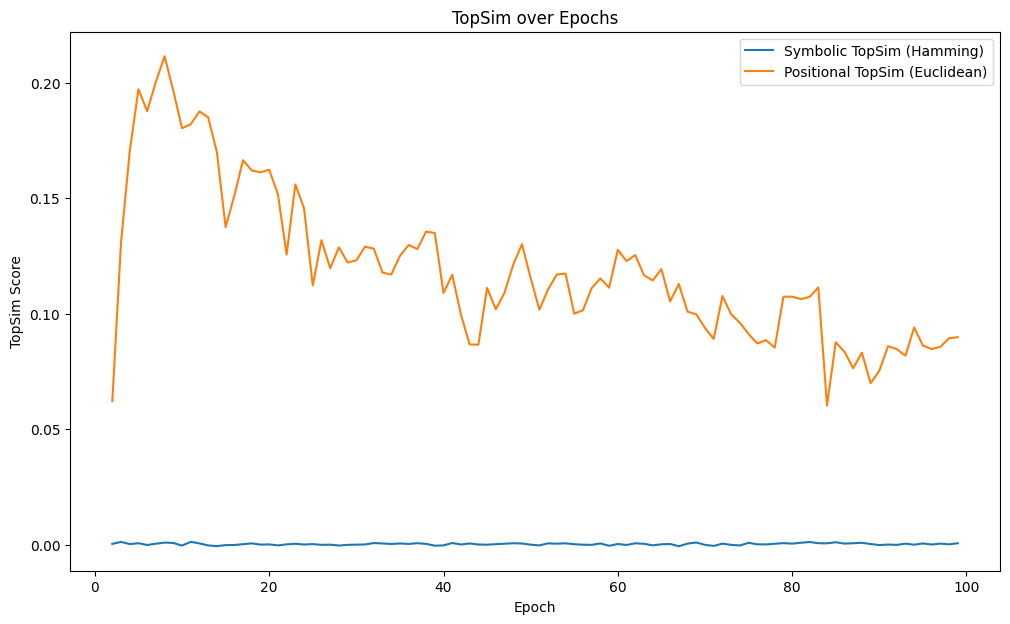

In [10]:
epochs = range(len(topsim_scores_over_epochs))

plt.figure(figsize=(12, 7))

plt.plot(epochs, topsim_scores_over_epochs, linestyle='-', label='Symbolic TopSim (Hamming)')
plt.plot(epochs, pos_topsim_scores_over_epochs, linestyle='-', label='Positional TopSim (Euclidean)')

plt.title('TopSim over Epochs')
plt.xlabel('Epoch')
plt.ylabel('TopSim Score')
plt.legend()

plt.show()